In [1]:
from __future__ import print_function
import numpy as np
from SimPEG import Mesh
from SimPEG import Problem
from SimPEG import Survey
from SimPEG import DataMisfit
from SimPEG import Directives
from SimPEG import Optimization
from SimPEG import Regularization
from SimPEG import InvProblem
from SimPEG import Inversion
from SimPEG import Maps
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Mag Inversion

## Step1: Generating mesh

In [2]:
np.random.seed(1)

N = np.r_[np.ones(25), np.ones(25)*2]/75 * np.pi
std_noise = 0.1

mesh = Mesh.TensorMesh([N])

m0 = np.ones(mesh.nC) * 1e-4
mref = np.zeros(mesh.nC)

nk = 4
jk = np.linspace(1., nk, nk)
p = 1.0
q = 1.1
winSize = 20
center = np.linspace(0,mesh.nC,nk+2, dtype=int)

np.random.seed()
def g(k):
#     return ((1)**(k)*
#         np.exp(-p*(k+1)*mesh.vectorNx[:-1]*np.pi/mesh.vectorNx[-1]) *
#         np.cos(q*(k)*mesh.vectorNx[:-1]*np.pi/mesh.vectorNx[-1])
#     )
    
#     xmin, xmax = np.max([0,center[k+1]-winSize]), np.min([mesh.vnC[0],center[k+1]+winSize+1])
#     kernel = np.zeros(mesh.nC)
    
#     kernel[xmin:xmax] = 1 

#     return np.random.rand(mesh.nC)
    return (1)**(k)*np.cos(p*(k+1)*mesh.vectorCCx + np.pi/8)

#     return (
#         np.exp(-p*(k+1)**2.*mesh.vectorNx[:-1]/mesh.vectorNx[-1]))
F = np.zeros((nk, mesh.nC))

for i in range(nk):
    F[i, :] = g(i)

# Add square anomaly
mtrue = np.zeros(mesh.nC)
mtrue[20:30] = 0.25
# mtrue[30:32] = 0.25
# mtrue[40:45] = 0.25

# Add Gaussian anomaly
# cntr = mesh.vectorCCx[35]
# mtrue += 0.3* np.exp(-(((mesh.vectorCCx-cntr) /5)**2. ))

# mtrue[60] = -0.5
# mtrue[mesh.vectorCCx > 0.6] = 0


# indx = np.random.randint(0,mesh.nC,10)
# mtrue[indx] = np.random.rand(10)

prob = Problem.LinearProblem(mesh, F=F)
survey = Survey.LinearSurvey()
survey.pair(prob)

data = prob.fields(mtrue)
survey.dobs = data + std_noise * np.random.randn(nk)

wd = np.ones(nk) * std_noise

# Distance weighting
wr = np.sum(prob.F**2., axis=0)**0.5
wr = wr/np.max(wr)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=mesh.nC)

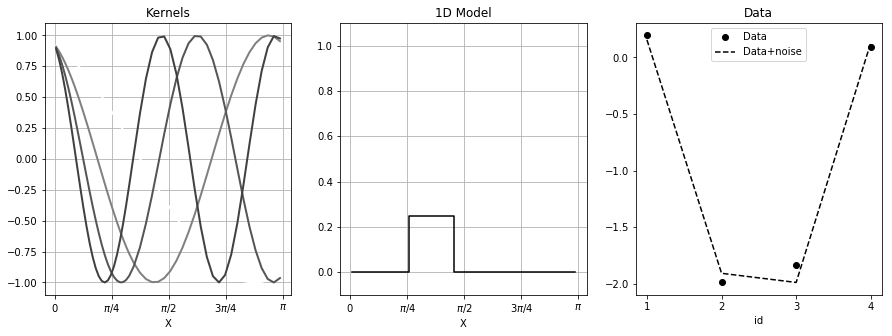

In [3]:
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1,3,1)
for i in range(prob.F.shape[0]):
    ax1.plot(mesh.vectorCCx, prob.F[i, :], color=np.r_[1,1,1]/(i+1), lw=2)
ax1.set_title('Kernels')
ax1.set_xticks(np.linspace(0,np.pi,5))
ax1.set_xticklabels(['$0$','$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$'])
ax1.set_xlabel("X")
ax1.grid('on')

ax2 = plt.subplot(1,3,2)
ax2.step(mesh.vectorCCx, mtrue, 'k-')
ax2.grid('on')
ax2.set_xlabel("X")
ax2.set_xticks(np.linspace(0,np.pi,5))
ax2.set_xticklabels(['$0$','$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$'])
ax2.set_title('1D Model')
ax2.set_ylim(-.1, 1.1)

ax3 = plt.subplot(1,3,3)
ax3.plot(data,'ko')
ax3.plot(survey.dobs,'k--')
ax3.set_title('Data')
ax3.set_xlabel("id")
ax3.set_xticks(range(0,nk))
ax3.set_xticklabels(range(1,nk+1))
ax3.legend(['Data', 'Data+noise'])
plt.show()

fig.savefig('Problem1D_KernelModel.png',bbox_inches='tight')

## Step2: Generating Model



In [4]:
prob = Problem.LinearProblem(mesh, F=F)
survey = Survey.LinearSurvey()
survey.pair(prob)
survey.makeSyntheticData(mtrue, std=1.0)

wr = np.sum(prob.F**2., axis=0)**0.5

reg_t = Regularization.Tikhonov(mesh, alpha_s=1./mesh.hx.min()**2., alpha_x=1.)
reg_t.cell_weights = wr/mesh.vol
reg_t.mref = np.zeros_like(mtrue)

dmis_t = DataMisfit.l2_DataMisfit(survey)
dmis_t.W = 1./survey.std

opt_t = Optimization.ProjectedGNCG(maxIter=100, lower=-2., upper=2.,
        maxIterLS=20, maxIterCG=100, tolCG=1e-3,
        tolG = -1, eps=-1,
        tolF = -1, tolX= -1
    )

invProb_t = InvProblem.BaseInvProblem(dmis_t, reg_t, opt_t, beta=1.5e+3)

directives = [
    Directives.TargetMisfit(chifact=1.),
    Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
]
inv = Inversion.BaseInversion(invProb_t, directiveList=directives)
m0 = np.ones_like(survey.mtrue)*1e-4

mrec_Thikonov = inv.run(m0)



SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.50e+03  2.43e+00  1.94e-04  2.72e+00    1.41e+01      0              

                Default solver: SolverDiag is being used in bfgsH0
                
   1  7.50e+02  2.43e+00  3.23e-08  2.43e+00    5.51e+00      0              
   2  3.75e+02  2.43e+00  1.29e-07  2.43e+00    5.51e+00      0   Skip BFGS  
   3  1.88e+02  2.43e+00  5.17e-07  2.43e+00    5.51e+00      0   Skip BFGS  
   4  9.38e+01  2.43e+00  2.07e-06  2.43e+00    5.51e+00      0   Skip BFGS  
   5  4.69e+01  2.43e+00  8.26e-06  2.43e+00    5.51e+00      0   Skip BFGS  
   6  2.34e+01  2.43e+00  3.30e-05  2.43e+00    5.51e+00      0   Skip BFGS  
   7  1.17e+01  2.42e+

In [5]:
dmis_s = DataMisfit.l2_DataMisfit(survey)
dmis_s.W = 1./wd

reg_s = Regularization.Sparse(mesh, mapping=idenMap, gradientType='components')
reg_s.mref = mref

opt_s = Optimization.ProjectedGNCG(
    maxIter=100, lower=-2., upper=2.,
    maxIterLS=20, maxIterCG=100, tolCG=1e-3,
    tolG = -1, eps=-1,
    tolF = -1, tolX= -1
)
invProb_s = InvProblem.BaseInvProblem(dmis_s, reg_s, opt_s, beta=1.5e+3)
update_Jacobi = Directives.UpdateJacobiPrecond()

saveDict = Directives.SaveOutputDictEveryIteration()
IRLS = Directives.Update_IRLS(maxIRLSiter=100, minGNiter=1, updateGamma=False,
                              coolEpsFact=1.2, f_min_change = 1e-1,
                             chifact_start=1.,chifact_target=1., coolEps_p=True, coolEps_q=True,
                             floorEps_p = 1e-4, floorEps_q = 1e-4)

inv_s = Inversion.BaseInversion(
    invProb_s,
    directiveList=[saveDict, IRLS, update_Jacobi]
)

inv_s.run(np.ones_like(survey.mtrue)*1e-4)

mrec_Simple = invProb_s.l2model

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2018-03-24-11-48.npz'
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.50e+03  2.43e+02  2.50e-07  2.43e+02    1.41e+01      0              
   1  7.50e+02  3.72e+01  3.82e-02  6.58e+01    1.37e+01      0              
   2  3.75e+02  1.45e+01  5.91e-02  3.67e+01    1.36e+01      0   Skip BFGS  
   3  1.88e+02  4.75e+00  7.69e-02  1.92e+01    1.34e+01      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.1122606322565389 eps_q: 0.02327460533312866
Eps_p: 0.09355052688044908
Eps_q: 0.0193955

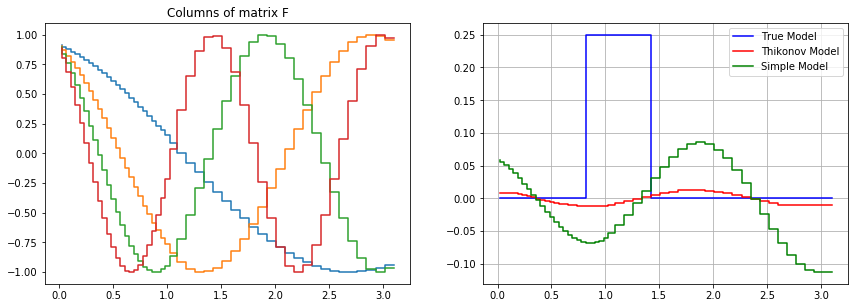

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12*1.2, 4*1.2))
for i in range(prob.F.shape[0]):
    axes[0].step(mesh.vectorCCx,prob.F[i, :])
axes[0].set_title('Columns of matrix F')

axes[1].step(mesh.vectorCCx, mtrue, 'b-')
axes[1].step(mesh.vectorCCx, mrec_Thikonov, 'r-')
axes[1].step(mesh.vectorCCx, mrec_Simple, 'g-')
axes[1].legend(('True Model', 'Thikonov Model', 'Simple Model'))
# axes[1].set_ylim([-0.1, 0.4])
axes[1].grid(True)

plt.savefig('InvModel_1Bigcell_mixWr.png')

NameError: name 'invProb' is not defined

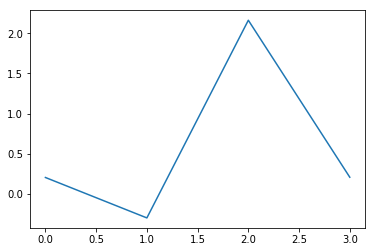

In [7]:
plt.figure()
plt.plot(survey.dobs)
plt.plot(invProb.dpred)


In [ ]:
phim = [saveDict.outDict[ii+1]['phi_m'] for ii in range(len(saveDict.outDict.keys()))]
iter = [saveDict.outDict[ii+1]['iter'] for ii in range(len(saveDict.outDict.keys()))]

In [ ]:
plt.plot(iter, phim)

In [ ]:
pctVal[7]

In [ ]:
import scipy.sparse as sp
Japprox = np.sum(prob.G**2., axis=0)**0.5
pctVal = np.percentile(Japprox,np.asarray(range(20))*5)

step = mrec_Simple - m0

indx = Japprox > pctVal[7]
P = sp.spdiags(indx*1.,0, mesh.nC, mesh.nC)

ddata = np.sum(((np.dot(prob.G,P*(step)) - survey.dobs)/survey.std)**2.)/2
print(ddata)
plt.figure()
plt.plot(np.dot(prob.G*P,step))
plt.plot(survey.dobs)


In [ ]:
invProb.phi_d
